Load dataset and visualize some samples

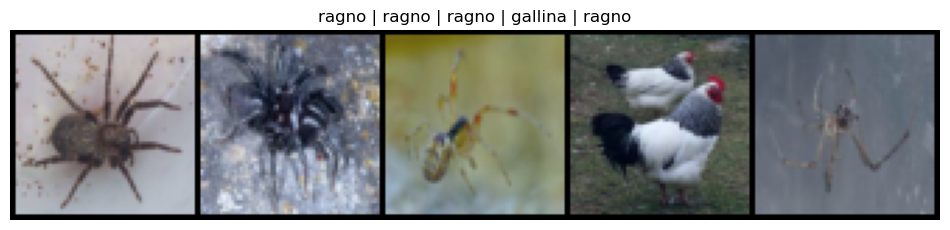

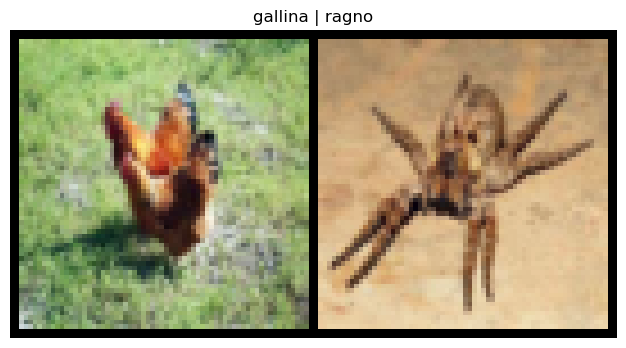

In [1]:
from torchvision import transforms, utils
from Dataset import CustomImageDataset

NUM_OF_CLASSES = 2
transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = CustomImageDataset('data/raw-img', transform=transform, amount_of_classes=NUM_OF_CLASSES, 0.1)

dataset.visualize(5)

dataset.visualize_all_classes()

#print(dataset.nr_classes)

In [2]:
#define model

import torch.nn as nn
import torch.nn.functional as F

class ClassificationModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ClassificationModel, self).__init__()
        
        # First convolutional layer: 3 input channels (RGB), 32 output channels, kernel size 5, padding 2 to preserve size
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        
        # Second convolutional layer: outputs a 32-channel feature map
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        
        # Third convolutional layer: further reduces spatial dimensions
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)

        # Fully connected layer
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Adjusted for the final size after pooling
        
        # Prediction layer
        self.prediction = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Input size is assumed to be (batch_size, 3, 500, 500)
        
        # First conv -> ReLU -> Max Pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)  # Output: (batch_size, 32, 32, 32)

        # Second conv -> ReLU -> Max Pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)  # Output: (batch_size, 64, 16, 16)

        # Third conv -> ReLU -> Max Pooling
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2)  # Output: (batch_size, 128, 8, 8)

        # Flatten the tensor for fully connected layer
        x = x.view(x.size(0), -1)  # Output: (batch_size, 128 * 62 * 62)

        # Fully connected layer -> ReLU
        x = F.relu(self.fc1(x))

        # Output layer (no activation, to be combined with a loss function later)
        x = self.prediction(x)
        x = nn.Softmax(dim=1)(x)  # Specify dim=1 to apply Softmax over class scores

        return x
    



In [3]:
from torchsummary import summary
model = ClassificationModel(num_classes=NUM_OF_CLASSES)

summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           2,432
            Conv2d-2           [-1, 64, 32, 32]          51,264
            Conv2d-3          [-1, 128, 16, 16]         204,928
            Linear-4                  [-1, 512]       4,194,816
            Linear-5                    [-1, 2]           1,026
Total params: 4,454,466
Trainable params: 4,454,466
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.75
Params size (MB): 16.99
Estimated Total Size (MB): 18.79
----------------------------------------------------------------


Starting training on device:  mps

Epoch: 0
0.7629960672415558 Epoch:  0

Epoch: 1
0.6424764804277375 Epoch:  1

Epoch: 2
0.5758970180055596 Epoch:  2

Epoch: 3
0.5337391416710681 Epoch:  3

Epoch: 4
0.49997572944270174 Epoch:  4

Epoch: 5
0.4198532400554999 Epoch:  5

Epoch: 6
0.3974792533326691 Epoch:  6

Epoch: 7
0.345211142773803 Epoch:  7

Epoch: 8
0.2965707931322407 Epoch:  8

Epoch: 9
0.26097582254979285 Epoch:  9

Epoch: 10
0.25072214804679965 Epoch:  10

Epoch: 11
0.1728467724622608 Epoch:  11

Epoch: 12
0.21646318433167464 Epoch:  12

Epoch: 13
0.09253906026253853 Epoch:  13

Epoch: 14
0.3527420081193067 Epoch:  14

Epoch: 15
0.24459122539416797 Epoch:  15

Epoch: 16
0.09080303030236961 Epoch:  16

Epoch: 17
0.1926902939276519 Epoch:  17

Epoch: 18
0.08449190479456993 Epoch:  18

Epoch: 19
0.07323967318481932 Epoch:  19

Epoch: 20
1.1185049258430335 Epoch:  20


/Users/isakknutsson/Desktop/Classification-Game/test_model.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, requires_grad=False)


2


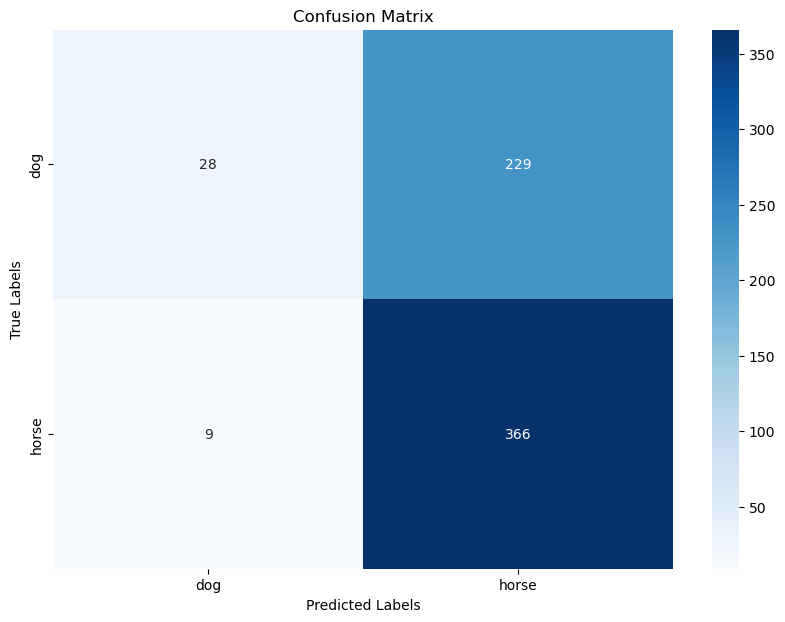

Accuracy of the network on the test images: 62 %
62.34177215189873


In [4]:
from models.ClassificationModel import ClassificationModel
from train import train
import torch.optim
from torch.utils.data import DataLoader, random_split
import torch.nn as nn

device = 'mps'

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size   # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=5, shuffle=False)




optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


model.to(device)

model, loss, acc = train(model, train_loader, val_loader, optimizer, criterion, device, 0 , 20, "hej", 1232)
from test_model import test
accuracy = test(model, train_loader, device, "hej", 1111)

print(accuracy)